**Analysis owner**: Tamiris Crepalde <br>
**Date**: 25/02/2023 <br>

#### Summary 

1. Introdution
<br></br>
1. Kaplan-Meier Curve
<br></br>
1. Log Rank Test
<br></br>
1. Cox Proportional Hazards Model
<br></br>
1. Conclusions
<br></br>

<h2> Introduction

As said before, travel packages have a wide variety of valid periods and flexible cancellation policies. And understanding the Survival Time of a purchase can help financial and commercial planning. The time to a event we are interested in is the time to cancel a order after the purchase.

We'll try to identify the time of cancellation after a purchase through Survival Time Analysis. For this, the following statements will be considered:
- the start time is the moment of the order;
- the event time is the time of the last status change for canceled orders;
- the time to the event is the time_to_cancel_days feature; 

If the order was not canceled, then the case will be considered Censored Data.
<br></br>

<br></br>
<h3> Setup

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

import src.visualization.visualization_utils as visuals

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
root = os.getcwd()

<br></br>
<h3> Load Data

In [3]:
df = pd.read_csv(f'{root}/src/data/package_data_processed.csv')

In [4]:
df.head()

,origin_city,origin_state,destination_type,destination_city,destination_state,destination_country,qty_people,qty_dailies,accommodation_type,qty_status_changes,operation_started,order_canceled,time_to_cancel_days,time_to_cancel_months,last_fill_to_cancel_days,last_fill_to_cancel_months
0,0,0,1,0,0,0,2,5,0,1,1,0,0,0,0,0
1,11,11,1,111,47,0,2,5,0,1,1,0,0,0,0,0
2,11,11,1,155,58,0,1,6,1,1,1,0,0,0,0,0
3,11,11,1,166,69,0,1,4,0,3,0,1,583,19,583,19
4,11,11,0,177,80,11,4,6,0,1,1,0,0,0,0,0


<br></br>
<h3> Data Preparation

We'll truncate the dataset to 
- minimize the impact of data which we can consider as outliers
- to remove negative time interval
- to remove cases cancelled in 0 days

We'll consider outliers the cases above the upper limit of the following boxplot, with time_to_cancel bigger than 750 days.

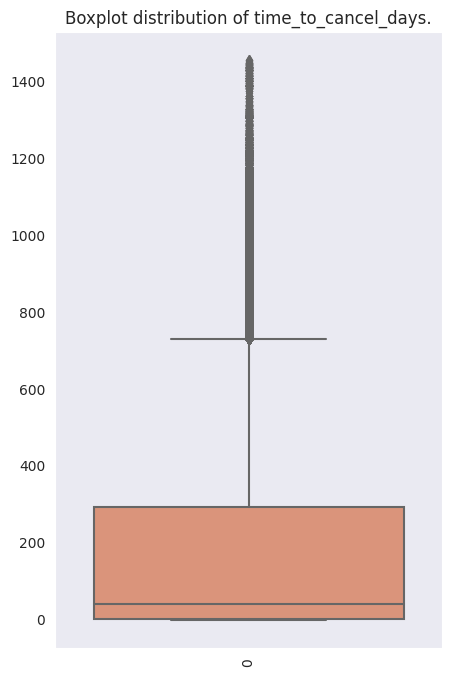

In [5]:
visuals.single_boxplot(df, 'time_to_cancel_days')

We'll also remove negative values and the cases with zero days to cancel.

In [9]:
df.time_to_cancel_days.sort_values().head(20)

213860   -1
502564   -1
393229   -1
456479   -1
439919   -1
480383   -1
476998   -1
827115   -1
28991    -1
450306   -1
398034   -1
39907    -1
375919   -1
5338     -1
401634   -1
536898    0
536891    0
536892    0
536909    0
536904    0
Name: time_to_cancel_days, dtype: int64

In [11]:
df = df.loc[(df.time_to_cancel_days > 0) & (df.time_to_cancel_days < 750)]

<br></br>
<h4> Kaplan-Meier Curve

Let's see the graphic representation of the survival rate for time_to_cancel_days using the Kaplan-Meier (KM) curve.

From the curve below, it's possible to notice that at least 60% of the orders survives after one year (365 days). The median survival time is 436 days, almost 1.2 years.

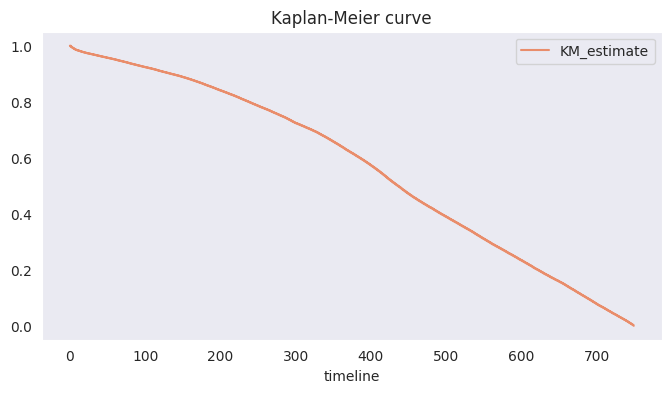

In [14]:
kmf = KaplanMeierFitter()
kmf.fit(df['time_to_cancel_days'], df['order_canceled'])

plt.figure(figsize=(8,4))
kmf.plot()
plt.title("Kaplan-Meier curve");

In [32]:
print(f'Median survival time is {kmf.median_survival_time_}')

Median survival time is 436.0


In the previous EDA we verified that the feature `operation_started` is the second most important feature impacting package cancellation. So let's fit and plot KM curves considering this feature.

The curve related to the cases which had the operation started clearly has a bigger median survival time than the other one. With 400 days, less than 40% of the cases which not had the operation started survived. In contrast, almost 80% of the cases with started operations had survived after 400 days.

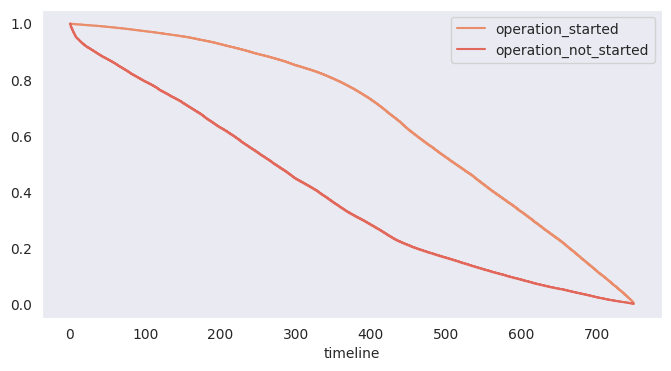

In [30]:
kmf_op_st = KaplanMeierFitter()
kmf_op_nost = KaplanMeierFitter()

plt.figure(figsize=(8,4))
ax = plt.subplot(111)
ax = kmf_op_st.fit(df.loc[df.operation_started == 1]['time_to_cancel_days'], df.loc[df.operation_started == 1]['order_canceled'], label ='operation_started').plot(ax=ax)
ax = kmf_op_nost.fit(df.loc[df.operation_started == 0]['time_to_cancel_days'], df.loc[df.operation_started == 0]['order_canceled'], label ='operation_not_started').plot(ax=ax)

In [31]:
print(f'Median survival time for started operations is {kmf_op_st.median_survival_time_}')
print(f'Median survival time for not started operations is {kmf_op_nost.median_survival_time_}')

Median survival time for started operations is 512.0
Median survival time for not started operations is 272.0


<h3> Long Rank Test

We're going to use the Long Rank Test to verify the null hypothesis that 'operation started' and 'operation not started' survival curves are statistically equivalent:
- null hypothesis: the curves are statistically equivalent (p_value > 0.05)
- alternative hypothesis: the curves are not statistically equivalent

The p_value < 0.005 indicates that we can reject the null hypothesis, which means that the survival functions are not statistically equivalent.

In [45]:
results = logrank_test(
    df.loc[df.operation_started == 1]['time_to_cancel_months'], 
    df.loc[df.operation_started == 0]['time_to_cancel_months'], 
    event_observed_a = df.loc[df.operation_started == 1]['order_canceled'], 
    event_observed_b = df.loc[df.operation_started == 0]['order_canceled']
)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
  event_observed_a = 11        1
14        1
15        1
21        0
22        0
         ..
967428    0
967430    1
967431    0
967434    0
967435    0
Name: order_canceled, Length: 351398, dtype: int64
  event_observed_b = 3         1
9         1
10        1
18        1
26        1
         ..
967386    1
967392    1
967395    1
967410    1
967433    1
Name: order_canceled, Length: 136108, dtype: int64
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2660.97 <0.005       inf

<h4> Cox Proportional Hazards Model

Parametric survival analysis: a survival model is constructed by performing regression analysis on the assumption that the outcome variables follow a conventionally known distribution, such as normal distribution, binomial distribution, or Poisson distribution. Common parametric survival models: Weibull, exponential, log-logistic, lognormal, and generalized gamma.

- Kaplan Meier Curve
  - used to graphically represent the survival rate or survival function


- Log Rank Test
  - compares the distribution of the time until an event occurs of two or more independent samples
  - null hypothesis: the groups have identical distribution curves
  - alternative hypothesis: the groups have different distribution curves
  - log rank test -> p-value -> p-value greater than 0.05?
    - yes -> null hypothesis is retained, both groups have identical distribution curves
    - no -> null hypothesis is rejected


- Cox Proportional Hazards Model (Cox regression)
  - want to check if there are other parameters that affect the curve

1. Censorship: Censored observations have the same survival prospects as uncensored observations.
2. Study entry time: Survival probabilities are the same for observations recruited early and later in the study.
3. Event time: Event happened at the defined time